In [5]:
import sys
sys.path.append('..')
sys.path.append('../..')

import copy
import math
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import wandb
from torch.optim.lr_scheduler import SequentialLR, LinearLR, ExponentialLR, CosineAnnealingLR
from torch.utils.data import DataLoader, Subset, random_split
from itertools import groupby
from operator import itemgetter

from data_utils import *
from model import *
from waveforms.waveforms_module.make_waveform import BatchedLightSimulation

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

g = torch.Generator()
g.manual_seed(seed)

In [6]:
# path = '/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delay_200ks/test.npy'
path = '/sdf/home/c/carsmith/sdf_data/self_supervised_flash/data/200k_3labels.npy'
train_loader, val_loader, test_loader = make_wf_dataloaders(path, batch_size=50, val_ratio=0.1, test_ratio=0.7, generator=g, norm=False)


data keys: dict_keys(['waveforms', 'arrival_times', 'num_photons', 'token_labels', 'last_phot_arrival'])


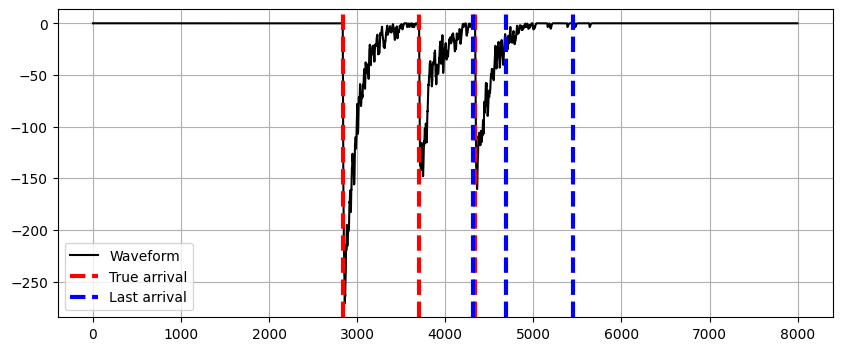

In [85]:
waveforms, arrival_times, hit_times, photon_bins, photon_list, last_phot_list, token_labels = next(iter(val_loader))
waveform_id = 0
wf = waveforms[waveform_id]  # [1, L]
ticks = torch.arange(wf.shape[-1])  # [0, 1, ..., L-1]
wf = wf.squeeze(0)  # [L]

plt.figure(figsize=(10, 4))
plt.grid(which='both')
# plt.plot(ticks, np.arcsinh(wf / 5), color='black', label="arcsinh(wf)")
plt.plot(ticks, wf, color='black', label="Waveform")

# Mark true hits
for j, t in enumerate(hit_times[waveform_id]):
    if t >= 0:
        plt.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=3, 
            label='True arrival' if j == 0 else ""
        )

# Mark latest photons
for j, t in enumerate(last_phot_list[waveform_id]):
    if t > 0:
        plt.axvline(
            x=t.item(), 
            color='b', 
            linestyle='--', 
            linewidth=3, 
            label='Last arrival' if j == 0 else ""
        )

plt.legend()

In [4]:
import torch
from collections import Counter

label_counts = Counter()

for batch in val_loader:
    *_, token_labels = batch   # shape [B, L]

    # Flatten from [B, L] → [B*L]
    labels_flat = token_labels.reshape(-1).cpu().tolist()

    # Update global counter
    label_counts.update(labels_flat)

print("Token counts:", label_counts)

Token counts: Counter({0: 8458646, 2: 7147867, 1: 393487})


Batch shape:  torch.Size([50, 1, 8000])
Arrival times shape:  torch.Size([50, 1, 8000])
Photon bins shape:  torch.Size([50, 1, 8000])
torch.Size([8000])
Total photons in wf:  3333


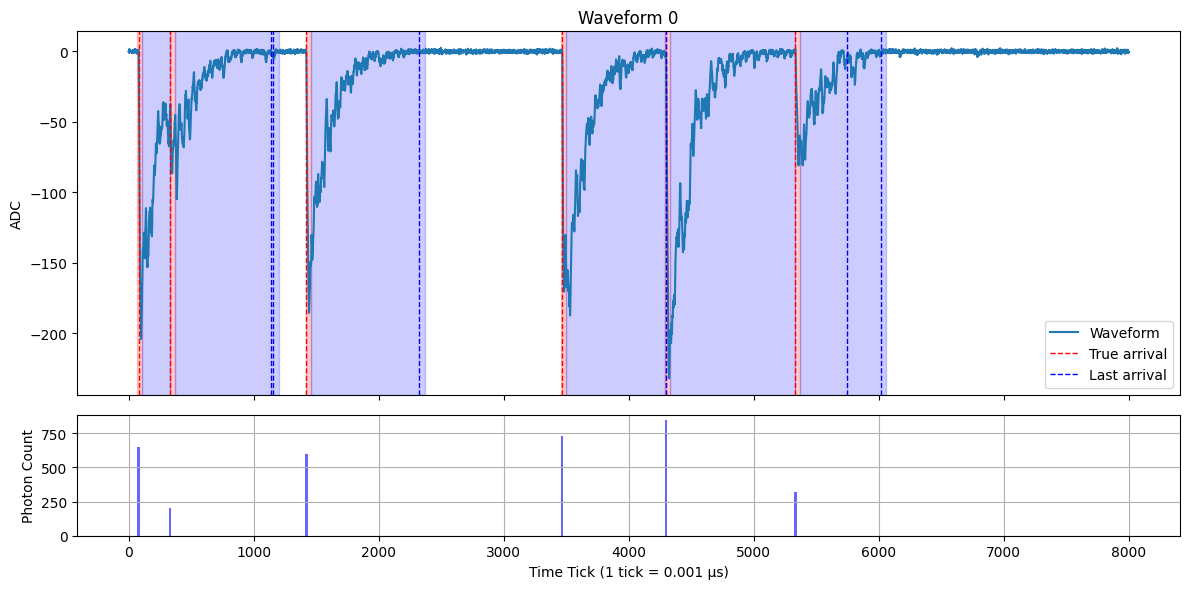

In [5]:
waveforms, arrival_times, hit_times, photon_bins, photon_list, last_phot_list, token_labels = next(iter(val_loader))
print('Batch shape: ', waveforms.shape)
print('Arrival times shape: ', arrival_times.shape)
print('Photon bins shape: ', photon_bins.shape)

waveform_id = 0
wf = waveforms[waveform_id]  # [1, L]
ticks = torch.arange(wf.shape[-1])  # [0, 1, ..., L-1]
wf = wf.squeeze(0)  # [L]

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 6), sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

# --- Top panel: waveform ---
ax1.plot(ticks, wf, alpha=1, label='Waveform')

# Mark true hits
for j, t in enumerate(hit_times[waveform_id]):
    if t >= 0:
        ax1.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )

# Mark latest photons
for j, t in enumerate(last_phot_list[waveform_id]):
    if t > 0:
        ax1.axvline(
            x=t.item(), 
            color='b', 
            linestyle='--', 
            linewidth=1, 
            label='Last arrival' if j == 0 else ""
        )
        
# Highlight signal regions based on labels
labels = np.repeat(token_labels[waveform_id], 10)
print(labels.shape)
signal_bins = np.where(labels == 1)[0]
tail_bins = np.where(labels == 2)[0]

# Group contiguous sequences in repeated array
for k, g in groupby(enumerate(signal_bins), lambda ix: ix[0] - ix[1]):
    group = list(map(itemgetter(1), g))
    ax1.axvspan(group[0], group[-1], color='red', alpha=0.2)
for k, g in groupby(enumerate(tail_bins), lambda ix: ix[0] - ix[1]):
    group = list(map(itemgetter(1), g))
    ax1.axvspan(group[0], group[-1], color='blue', alpha=0.2)

ax1.set_title(f"Waveform {waveform_id}")
ax1.set_ylabel("ADC")
ax1.legend()

# --- Bottom panel: photon counts ---
photon_counts = photon_bins[waveform_id].cpu().numpy()
print("Total photons in wf: ", photon_counts[0].sum())
ax2.bar(ticks, photon_counts[0], width=20.0, color='b', alpha=0.6)
ax2.set_ylabel("Photon Count")
ax2.set_xlabel("Time Tick (1 tick = 0.001 μs)")
ax2.grid()
plt.tight_layout()
plt.show()

### Load a Checkpoint

In [13]:
# Load the checkpoint
device = 'cuda'
model = ConformerModel()
model.to(device)
checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/self_supervised_flash/mae_con_200k/15.pth", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ConformerModel(
  (tokenizer): MultiLevelTokenizer(
    (convs): ModuleList(
      (0): Conv1d(1, 256, kernel_size=(20,), stride=(1,), padding=(10,))
      (1): Conv1d(1, 256, kernel_size=(50,), stride=(1,), padding=(25,))
      (2): Conv1d(1, 256, kernel_size=(100,), stride=(1,), padding=(50,))
      (3): Conv1d(1, 256, kernel_size=(400,), stride=(1,), padding=(200,))
    )
    (downsample): Sequential(
      (0): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): GELU(approximate='none')
      (2): Conv1d(256, 256, kernel_size=(10,), stride=(10,), groups=256, bias=False)
      (3): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
    (proj): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
  )
  (positional_encoding): PositionalEncoding()
  (conformer): Conformer(
    (conformer_layers): ModuleList(
      (0-3): 4 x ConformerLayer(
        (ffn1): _FeedForwardModule(
          (sequential): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwi

### Silhouette Score (Clustering)

In [14]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [15]:
# Extract some embeddings
val_progress = tqdm(val_loader, desc="Scanning", leave=False, position=0)

all_val_embeddings = []
all_token_labels = []

with torch.no_grad():
    for data, target, hit_times, photon_target, photon_list, _, token_labels in val_progress:
        data = data.to(device)
        embeddings = model(data, mode='just_embeddings')
        all_val_embeddings.append(embeddings.cpu())  # store on CPU to save GPU memory
        all_token_labels.append(token_labels)

all_val_embeddings = torch.cat(all_val_embeddings, dim=0)
all_token_labels = torch.cat(all_token_labels, dim=0)
print(all_val_embeddings.shape)
print(all_token_labels.shape)

torch.Size([20000, 800, 256])
torch.Size([20000, 800])


### t-SNE

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

B, T, D = all_val_embeddings.shape
X = all_val_embeddings.reshape(B*T, D)
Y = all_token_labels.reshape(B*T)

# downsample first — 3k–5k points is the sweet spot
idx = torch.randperm(B*T)[:100000]
X_subset = X[idx]
Y_subset = Y[idx]

# normalize and compress
X_subset = StandardScaler().fit_transform(X_subset).astype('float32')
X_pca = PCA(n_components=30, random_state=42).fit_transform(X_subset)

# t-SNE with moderate perplexity
tsne = TSNE(
    n_components=2,
    perplexity=5,
    learning_rate=200,
    n_iter=1000,
    random_state=42,
    verbose=1
)
embedding = tsne.fit_transform(X_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.001s...
[t-SNE] Computed neighbors for 100000 samples in 6.567s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probabi

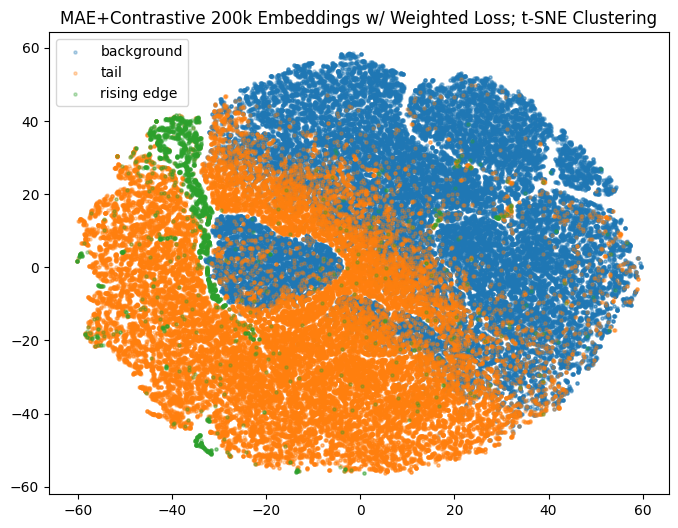

In [20]:
plt.figure(figsize=(8, 6))
for label in [0, 2, 1]:  # plot background, tail, then rising edge
    idx = (Y_subset == label)
    if label == 0: l = 'background'
    elif label == 2: l = 'tail'
    elif label == 1: l = 'rising edge'
    
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=l, s=5, alpha=0.3)
plt.legend()
plt.title("MAE+Contrastive 200k Embeddings w/ Weighted Loss; t-SNE Clustering")
plt.show()

Index(['Step', 'mask50_token10 - train_loss',
       'mask50_token10 - train_loss__MIN', 'mask50_token10 - train_loss__MAX',
       'mask80_token10 - train_loss', 'mask80_token10 - train_loss__MIN',
       'mask80_token10 - train_loss__MAX'],
      dtype='object')


Text(0.5, 1.0, 'Masked Vanilla DINO Training Loss')

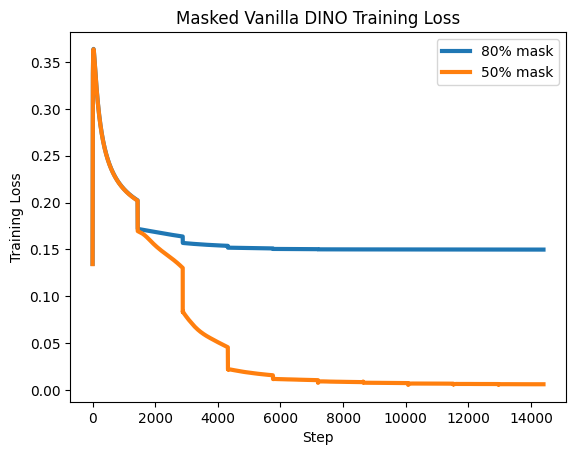

In [35]:
import pandas as pd
training_data = pd.read_csv('masked_training.csv')
print(training_data.keys())
plt.plot(training_data['Step'], training_data['mask80_token10 - train_loss'], label='80% mask', linewidth=3)
plt.plot(training_data['Step'], training_data['mask50_token10 - train_loss'], label='50% mask', linewidth=3)
plt.legend()
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.title('Masked Vanilla DINO Training Loss') 

In [ ]:
# Validation accuracy plots for unbalanced and balanced MAE
df = pd.read_csv('mae_test.csv')

In [ ]:
%run detection_training.py